## Different weighting strategy

In [1]:
#%load_ext watermark
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
from pybpr import *
import matplotlib.pyplot as plt
from functools import partial
import itertools
import scipy.sparse as ss
import pathos.multiprocessing as mp
import tqdm

In [3]:
cf = cf_4user_5item

In [4]:
print(cf)

--UserItemInteractions: Sample
  Number of users = 4
  Number of items = 5
  Number of interactions = 10



In [5]:
cf.R.todense()

matrix([[1, 1, 1, 0, 1],
        [1, 0, 1, 1, 0],
        [1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]], dtype=int8)

In [6]:
get_interaction_weights(cf.R, strategy='same')

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [7]:
np.around(get_interaction_weights(cf.R, strategy='positive-only'),2)

array([[1., 1., 1., 0., 1.],
       [1., 0., 1., 1., 0.],
       [1., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [8]:
np.around(get_interaction_weights(cf.R, strategy='uniformly-negative'),2)

array([[1.  , 1.  , 1.  , 0.99, 1.  ],
       [1.  , 0.56, 1.  , 1.  , 0.87],
       [1.  , 1.  , 0.21, 0.98, 0.33],
       [0.94, 1.  , 0.42, 0.74, 0.95]])

In [9]:
np.around(get_interaction_weights(cf.R, strategy='user-oriented'),2)

array([[1.  , 1.  , 1.  , 1.  , 1.  ],
       [1.  , 0.75, 1.  , 1.  , 0.75],
       [1.  , 1.  , 0.5 , 0.5 , 0.5 ],
       [0.25, 1.  , 0.25, 0.25, 0.25]])

In [10]:
np.around(get_interaction_weights(cf.R, strategy='item-oriented'),2)

array([[1.  , 1.  , 1.  , 0.67, 1.  ],
       [1.  , 0.  , 1.  , 1.  , 0.67],
       [1.  , 1.  , 0.33, 0.67, 0.67],
       [0.  , 1.  , 0.33, 0.67, 0.67]])

## Junk

In [11]:
df = load_movielens_data('ml-100k')
dfshort = df[df['rating'] > 0]
cf = UserItemInteractions(
    name='MovieLens-1m',
    users = dfshort['user_id'], 
    items = dfshort['item_id'],
    min_num_rating_per_user=10,
    min_num_rating_per_item=10
)
cf.generate_train_test(user_test_ratio=0.2)
num_users, num_items = cf.R.shape

In [20]:
num_users, num_items, cf.sparsity

(943, 1152, 0.090168)

Text(0.5, 0, 'Weights for negative samples')

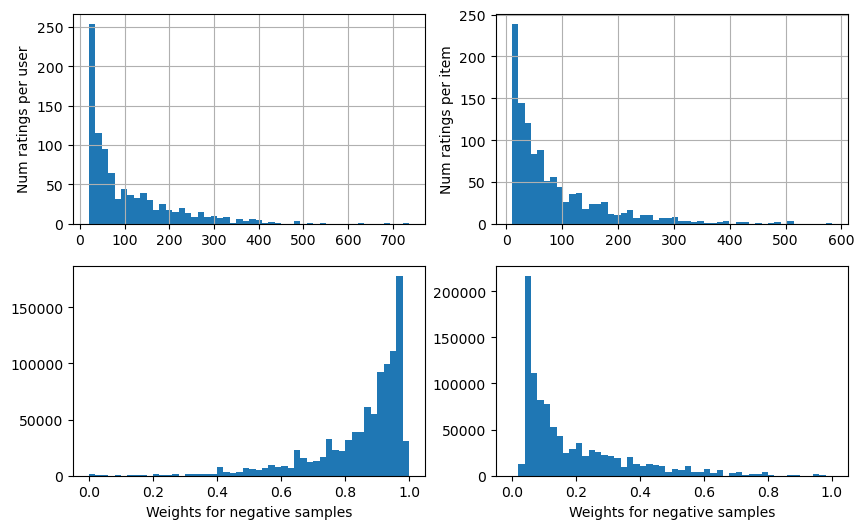

In [18]:
fig, ax = plt.subplots(2,2,figsize=(10,6))
ax = ax.flatten()
cf.df_user.NumRatings.hist(bins=50, ax=ax[0])
ax[0].set_ylabel('Num ratings per user')
cf.df_item.NumRatings.hist(bins=50, ax=ax[1])
ax[1].set_ylabel('Num ratings per item')
wgt = get_interaction_weights(cf.R, strategy='item-oriented', fac=500)
_ = ax[2].hist(wgt[wgt<1.], bins=50, range=(0,1))
ax[2].set_xlabel('Weights for negative samples')
wgt = get_interaction_weights(cf.R, strategy='user-oriented', fac=500)
_ = ax[3].hist(wgt[wgt<1.], bins=50,range=(0,1))
ax[3].set_xlabel('Weights for negative samples')

In [1]:
%%time
wgt_mat = np.around(get_interaction_weights(cf.R, strategy='user-oriented'),2)
item_wgt_tensor = np.zeros([num_users, num_items, num_items],dtype='float32')
item_index = np.arange(num_items)
item_wgt_tensor[:, item_index, item_index] = wgt_mat

user_wgt_tensor = np.zeros([num_items, num_users, num_users])
user_index = np.arange(num_users)
user_wgt_tensor[:, user_index, user_index] = wgt_mat.T

NameError: name 'np' is not defined

In [16]:
item_wgt_tensor.dtype

dtype('float32')

In [17]:
item_mat = np.random.normal(
    loc=0.,
    scale=0.01,
    size=(num_items, 20)
).astype('float32')
user_mat = np.zeros((num_users, 20),dtype='float32')
def update(data_mat, latent_mat, wgt_tensor):
        """WALS update step"""
        Tmat = np.linalg.inv(latent_mat.T @ wgt_tensor @ latent_mat + np.eye(20))
        Smat = np.expand_dims(data_mat @ latent_mat,1) @ Tmat
        return Smat[:,0,:]

In [ ]:
for i in range(10):
    print(i)
    user_mat = update(cf.R, item_mat, item_wgt_tensor)
    item_mat = update(cf.R.T, user_mat, user_wgt_tensor)

In [ ]:
%%time
latent_mat = item_mat
wgt_tensor = item_wgt_tensor
data_mat = cf.R
#Tmat = np.moveaxis(latent_mat.T.dot(wgt_tensor).dot(latent_mat), 1, 0)
#Tmat = latent_mat.T.dot(wgt_tensor)
Tmat = np.linalg.inv(latent_mat.T @ wgt_tensor @ latent_mat + np.eye(20)*0.1)
Smat = np.expand_dims(data_mat @ latent_mat,1) @ Tmat
print(latent_mat.T.shape, wgt_tensor.shape, data_mat.shape, Tmat.shape, Smat[:,0,:].shape)

In [32]:
df.columns

Index(['product_id', 'user_id', 'click_created', 'search_url',
       'search_created', 'title', 'long_description', 'final_department_id',
       'price_us_usd', 'date_created', 'date_modified', 'is_customizable',
       'seller_id', 'store_id', 'group_id', 'product_url_en_us',
       'product_design_image_url_en_us', 'product_image_url_en_us',
       'product_type'],
      dtype='object')